In [1]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import datetime
from sklearn import preprocessing


pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/george/Downloads/My First Project-8d2170533b7e.json"
client = bigquery.Client()

/Users/george/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## merging wheather dataset into trip data.

## Here's a quick summary of the preprocessing steps taken in the SQL query below:
1. Decided to only incorporate cab rides that laster between 30 and 6500 seconds, decided anything that didnt fall under this category was probably an error in the reporting. 
2. Made sure the pickup and dropoff sports are not NULL
3. made sure the locations were between 30 and 50 latitude, and -65 and -80 longitude. This is roughly the zone that new york is in, and there are a few zeros in the dataset that should be filtered out

## Variables that were taken into account in the model
1. euclidean distance
2. pickup and dropoff lattitude and longitude
3. time of day
4. day the week
5. precipiation from wheather data


In [2]:
#SQL QUERY THAT MATCHES WHEATHER DATA
query = (
     '''SELECT * FROM
(
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
     EXTRACT (YEAR FROM pickup_datetime) as year_of_year
 FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` as trips
WHERE 
   (TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) BETWEEN 30 AND 6500) AND
    pickup_longitude IS NOT NULL AND
    pickup_latitude IS NOT NULL AND
  (pickup_latitude BETWEEN 30 AND 50) AND
  (pickup_longitude BETWEEN -80 AND -65) AND
  (dropoff_latitude BETWEEN 30 AND 50) AND
  (dropoff_longitude BETWEEN -80 AND -65)
)
LEFT JOIN
    (
     SELECT concat(year,'-',mo,'-',da) as date_of_year2, prcp
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) 
    on date_of_year2 = CAST( EXTRACT(DATE FROM pickup_datetime) as string )
ORDER BY RAND()
LIMIT 1000000
'''
)
    
df_raw=pd.io.gbq.read_gbq(query,dialect='standard')

print('done!') 



done!


In [38]:
#Import 2015 wheather data to join to test data

query = (
     '''
SELECT concat(year,'-',mo,'-',da) as date, prcp
     from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
     ''' )
    
prcp2015 = pd.io.gbq.read_gbq(query,dialect='standard')
    
print('done!')

done!


## Since we are given the test data as a csv file, will load the wheather data via SQL query and then join it in python.

In [24]:
test = pd.read_csv('APM4990_final_test_data.csv')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['total_minutes'] = test['pickup_datetime'].dt.hour*60 + test['pickup_datetime'].dt.minute
test['date'] = test['pickup_datetime'].dt.hour

#adding a date column to join with the wheather data
test['date'] = test['pickup_datetime'].dt.date

#will also find weekday for both df and test data using python dt function, to be consistent

test['weekday'] = test['pickup_datetime'].dt.dayofweek

In [34]:
#checking to see if coodinate inputs are bad
print np.shape( test[ test['pickup_latitude'] > 45 ] )
print np.shape( test[ test['pickup_longitude'] > -65 ] )
print np.shape( test['dropoff_latitude'] > 45 )

#there are some issues that should be fixed
#this is fixed after all the predictions are calculated, the bad cases will have their predictions set to the median
#there aren't many of these cases, so they won't have much of an impact of the median itself, if at all

(5, 8)
(19012, 8)
(1000000,)


In [12]:
df  = df_raw

#making a column of the time of day by minute, i.e. hour*60 + minute
df['total_minutes'] = df['pickup_datetime'].dt.hour*60 + df['pickup_datetime'].dt.minute
df['weekday'] = df['pickup_datetime'].dt.dayofweek

np.shape(df)


(1000000, 16)

In [93]:
print max(test['date'])
print min(test['date'])

2015-12-31
2015-01-01


In [13]:
#getting the distances for both train and test data, using haversine distance formula, and
#rounding earth's radius to 6371 km

a = np.sin((df['dropoff_latitude'] - df['pickup_latitude'] )*np.pi/360.0 )**2 + \
        np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * \
           np.sin( (df['dropoff_longitude']-df['pickup_longitude'])*np.pi/360.0)**2
           
df['dist'] = 6371 * 2 * np.arcsin(np.sqrt(a)) * 1000 #converting to meters


b = np.sin((test['dropoff_latitude'] - test['pickup_latitude'] )*np.pi/360.0 )**2 + \
        np.cos(test['pickup_latitude']) * np.cos(test['dropoff_latitude']) * \
           np.sin( (test['dropoff_longitude']-test['pickup_longitude'])*np.pi/360.0)**2
        

test['dist'] = 6371 * 2 * np.arcsin(np.sqrt(b)) * 1000 #converting to meters



/Users/george/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/george/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [64]:
#Joining wheather data to test data
prcp2015['date'] = pd.to_datetime(prcp2015['date']).dt.date

test = pd.merge(test, prcp2015, how='left', left_on = ['date'], right_on = ['date'] ).fillna(0)



In [70]:
#still some NA's from bad inputs, will set those to zero, and then set those predictiosn to the median values 
test = test.fillna(0)

df = df.dropna()
test.head()


,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,total_minutes,date,dist,weekday,prcp
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5,1312,2015-06-18,8199.384803,3,0.00
1,2015-02-04 18:12:51+00:00,40.763245,-73.992752,40.801430,-73.948372,2,1092,2015-02-04,6503.034866,2,0.00
2,2015-01-05 22:15:39+00:00,40.755505,-73.975273,40.746243,-73.979782,1,1335,2015-01-05,1144.567957,0,0.12
3,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1,142,2015-11-08,13345.370332,6,0.00
4,2015-10-21 04:27:55+00:00,40.759220,-73.980789,40.762402,-73.986458,1,267,2015-10-21,721.057731,2,0.00


## Also, since we're given the data as a csv, I can't compute the distance using the same st_distance bigquery SQL function. So instead, i'll change the way euclidean distance is calculated for botht eh training and the testing data (I don't expect this to make a big difference).

In [71]:
columns = ['dist','prcp','total_minutes', 'weekday', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

deg = 1

function = RandomForestRegressor(n_estimators = 50, max_depth = 30)


def train_predictor(function, df, columns, deg):
    y = df['travel_time']
    X = df[columns]
    
    fit = function.fit(X, y)
    fit_pred = fit.predict(X).reshape(-1, 1)
    
    model = LinearRegression(fit_intercept = True)
    
    #adding a polynomial fit to capture the dip in the trend
    regr = model.fit( PolynomialFeatures(degree = deg).fit_transform(fit_pred), y )
    #regr = model.fit(fit_pred, y_train)
    
    return(fit, regr)


fit, regr = train_predictor( function, df, columns, deg)


def make_predictions(fit, regr, test, deg):
    X = test[columns]
    pred = regr.predict(PolynomialFeatures(degree = deg).fit_transform( fit.predict(X).reshape(-1,1)))
    pred[pred < 20] = 45
    
    #then setting the entries with wrong lat/long coordinates to the median value
    median = pd.DataFrame(pred).median()

    pred[ test['pickup_latitude'] > 45 ] = median
    pred[ test['pickup_latitude'] < 35 ] = median
    pred[ test['dropoff_latitude'] > 45 ] = median
    pred[ test['dropoff_latitude'] < 35 ] = median
    pred[ test['pickup_longitude'] > -65 ] = median
    pred[ test['pickup_longitude'] < -80 ] = median
    pred[ test['dropoff_longitude'] > -65 ] = median
    pred[ test['dropoff_longitude'] < -80 ] = median
    
    
    return( pred )
    
    
pred = make_predictions(fit, regr, test, deg) 

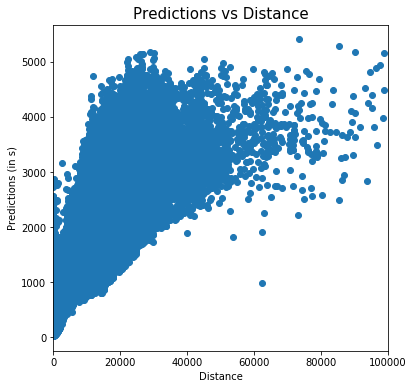

In [83]:
import matplotlib.pyplot as plt
x = test[:]

x['pred'] = pred

x = x[ x['dist'] < 200000 ]


plt.figure(figsize=(6, 6))
plt.title('Predictions vs Distance', fontsize=15)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Predictions (in s)', fontsize=10)
plt.scatter( x['dist'], x['pred'] )
plt.xlim((0, 100000))
plt.show()


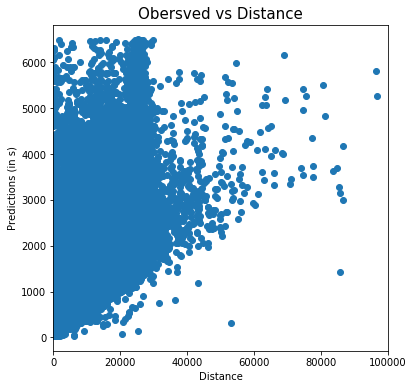

In [85]:
y = df[:]

y = y[ y['dist'] < 200000 ]


plt.figure(figsize=(6, 6))
plt.title('Obersved vs Distance', fontsize=15)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('trip time (in s)', fontsize=10)
plt.scatter( y['dist'], y['travel_time'] )
plt.xlim((0,100000))
plt.show()

In [95]:
#similar enough trends

## Now, adding the predictions column to the test data, and exporting it as a csv file

In [98]:
test['pred'] = pred

test.to_csv('predictions.csv')